# Applying the ResNet-50 to scaleograms as in Daydulo et al. 2022

[Daydulo et al. 2022](https://doi.org/10.1186/s12911-022-02068-1) - Deep learning based fetal distress detection from time frequency representation of cardiotocogram signal using Morse wavelet: research study.

Open Access This article is licensed under a Creative Commons Attribution 4.0 International License, which permits use, sharing, adaptation, distribution and reproduction in any medium or format, as long as you give appropriate credit to the original author(s) and the source, provide a link to the Creative Commons licence, and indicate if changes were made. The images or other third party material in this article are included in the article's Creative Commons licence, unless indicated otherwise in a credit line to the material. If material is not included in the article's Creative Commons licence and your intended use is not permitted by statutory regulation or exceeds the permitted use, you will need to obtain permission directly from the copyright holder. To view a copy of this licence, visit http://creativecommons.org/licenses/by/4.0/. The Creative Commons Public Domain Dedication waiver (http://creativecommons.org/publicdomain/zero/1.0/) applies to the data made available in this article, unless otherwise stated in a credit line to the data. Reprints and Permissions

## Background - CNNs and ResNet-50

### Neural networks

Neural networks are also known as artificial neural networks (ANN) or feed-forward (FF) neural networks. Information is only processed in a forward-facing direction (i.e. nodes never form a cycle).

Neural networks have an input layer, hidden layer/s, and an output layer. A layer is fully connected/dense if every node is connected to every node in the next layer.

<img src='images/neural_network.png' alt='Neural network' width='600'/>

For each node, values are input and then modified by:
* Weight (multiplies it by a certain value)
* Bias (adds a certain value)
* Activation function (e.g. ReLu accepts values over 0 but will convert any negatives to 0)

The network outputs a probability of an outcome. For a single outcome you can use sigmoid activation function to get a value between 0 and 1. For multiple outcomes, you use softmax.

![Neuron](images/neuron.png)

The model is first randomly initalised with random weights, and then these weights are optimised by the backpropagation algorithm and stochastic gradient descent (SGD):
* **Backpropagation** = starting from the output layer, work backwards through each layer, modifying the weights and biases so that the object is correctly classified
* **Stochastic gradient descent (SGD)** = we don't pass all the data through as that is computationally expensive - instead, we use SGD, which involves using random sampling to create mini-batches (subsets of the data, e.g. 32) and push those through - hence the name stochastic, since each time we train, we get slightly different weights due to the random sampling
* We find the best weights based on **minimising training error**. For classification models we use binary cross-entropy, and for regression models we use a loss metric like mean absolute error (MAE) or mean squared error (MSE)

Each forward and backward pass is one epoch (i.e. one training loop).

Types of neural network include:
* **Multilayer perceptron (MLP)** - term ambiguously used to refer to any neural network - or, to a specific classical type of neural network that has 3 layers, non-linear activation function, classifies data, fully connected.
* **Convolutional neural network (CNN)** - input 2D matrix or pass filter over pixels of image to detect shapes and objects
* **Recurrent neural networks (RNN)** - designed for sequence prediction problems, considers information from previously entered data and currently entered data, maintaining an internal state that saves data being fed into the network and uses state to predict outputs and subsequent inputs

Hyperparameters include:
* **Learning rate** - size of step for each iteration, larger step will descend more quickly but may overshoot and get issues with convergence
* **Momentum**
* **Adaptive learning rates** (e.g. Adam optimiser)

Prone to **overfitting** - methods for dealing with this include:
* **Dropout layers** - randomly choose neurons to turn off
* **Early stopping callbacks** - if patience=10, has there been any improvement in loss in the last 10 epochs, if not then stop and restore best weights

### About ResNet-50

ResNet-50 is a **pre-trained convolutional neural network** for image classification and computer vision. It has 50 layers - these include 48 convolution layers, 1 average pool layer, and 1 max pooling layer.

It is a residual network, which means it has **skip connections**. These help solve the vanishing gradient problem in deep neural networks. They connect a layer to further layers by skipping some inbetween, forming a residual block. A ResNet stacks these residual blocks together.

The vanishing/exploding gradient problem is that, when we increase the number of layers, the gradient becomes 0 or too larger, and so we see the training and test error rate increase with more layers.

<img src='images/resnet50_architecture_tds.png' alt='ResNet-50' width='600'/>

## Set up - import packages and set up environment for reproducible results

**Note:** The steps to enable reproducibility work at a low number of epochs (e.g. 4) but results do still start to differ between runs after a while.

We have to set PYTHONHASHSEED *before* importing tensorflow.

In [1]:
import os

# 1. Set PYTHONHASHSEED environment variable to 0
os.environ['PYTHONHASHSEED'] = '0'

In [2]:
# Import the other packages
import random
import numpy as np

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import pandas as pd

from PIL import Image

2023-12-15 13:53:43.206799: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-12-15 13:53:43.280169: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-15 13:53:43.280292: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-15 13:53:43.280392: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-15 13:53:43.294501: I tensorflow/core/platform/cpu_feature_g

Run the other steps for allowing reproducible results.

This follows the [Keras tutorial](https://keras.io/getting-started/faq/#how-can-i-obtain-reproducible-results-using-keras-during-development) and these stack overflow posts [[1]](https://stackoverflow.com/questions/50659482/why-cant-i-get-reproducible-results-in-keras-even-though-i-set-the-random-seeds), [[2]](https://stackoverflow.com/questions/32419510/how-to-get-reproducible-results-in-keras), on getting reproducible results during development.

In [3]:
def reset_seeds():
    '''
    Set the pseudo-random generators of python, numpy and tensorflow
    It is is important to call this function everytime before running the model
    '''
    random.seed(123)
    np.random.seed(123)
    tf.random.set_seed(123)

# 2. Set random seeds
reset_seeds()

# 3. Configure a new global tensorflow session
session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
tf.compat.v1.keras.backend.set_session(sess)

2023-12-15 13:53:47.120315: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-12-15 13:53:47.129316: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-12-15 13:53:47.129656: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

## First stage

### Import training, validation and test sets

Daydulo et al. 2022 state that they use a mini batch size of 30, with image size of 224 x 224 x 3.

In [4]:
# Define image size
height = 224
width = 224

In [5]:
# Import the training set
train_set = tf.keras.preprocessing.image_dataset_from_directory(
    'outputs/daydulo_cwt_first_stage/train/',
    image_size=(height,width), # Resize the images
    batch_size=30)

Found 629 files belonging to 2 classes.


2023-12-15 13:53:47.986805: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-12-15 13:53:47.987113: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-12-15 13:53:47.987283: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [6]:
# Import the validation set
validation_set = tf.keras.preprocessing.image_dataset_from_directory(
    'outputs/daydulo_cwt_first_stage/validation/',
    image_size=(height,width),
    batch_size=30)

Found 71 files belonging to 2 classes.


In [7]:
# Import the test set
test_set = tf.keras.preprocessing.image_dataset_from_directory(
    'outputs/daydulo_cwt_first_stage/test/',
    labels='inferred',
    image_size=(height, width),
    batch_size=30)

Found 78 files belonging to 2 classes.


In [8]:
# View the class names
train_set.class_names

['class_0_normal', 'class_1_distressed']

### Build the deep learning model

#### Daydulo et al. 2022

Implementation of ResNet50 in Python is based on [this tutorial](https://medium.com/@bravinwasike18/building-a-deep-learning-model-with-keras-and-resnet-50-9dd6f4eb3351), with details on attempts to match Daydulo parameters below.

Set up the ResNet-50 model.

In Daydulo et al. 2022:
* Input shape 224 x 224 x 3
* Not certain if imagenet weights were used

Architecture of the model is shown in a figure, which is just the default structure/image for a ResNet50 model. It is otherwise unclear if they made further modifications, such as whether their classification did include average pooling and fully connected 1000, and whether they included any dropout layers.

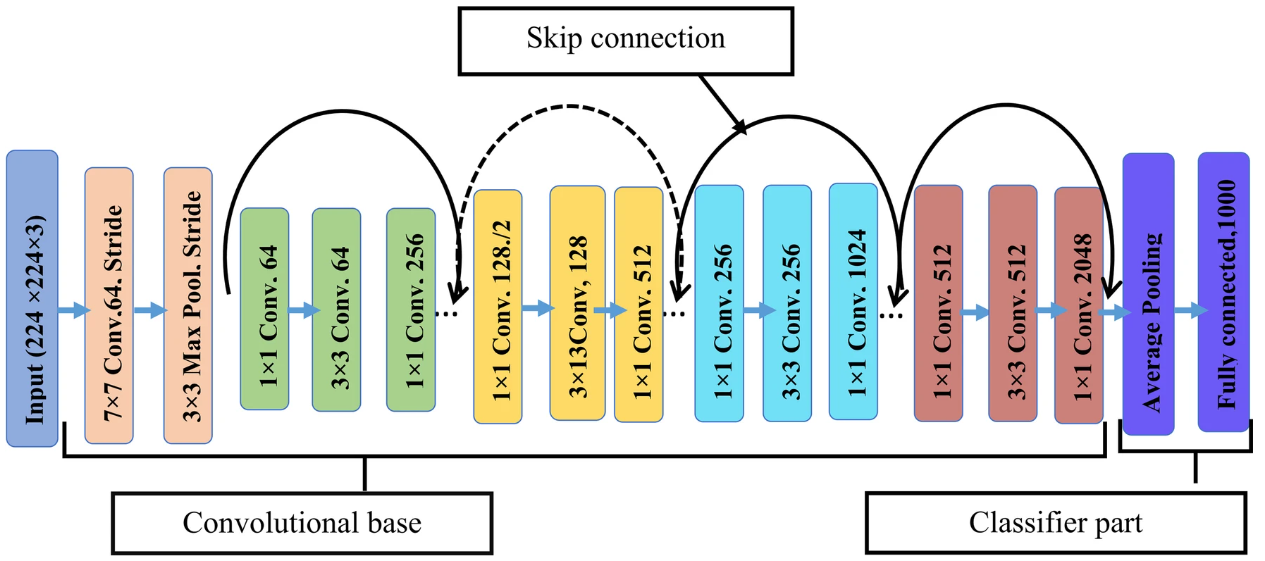

In [9]:
Image.open('images/daydulo_figure8.png')

#### Build , fit and evaluate the model

Build and compile the model. Building parameters as above, for compiling, Daydulo et al. 2022 parameters:
* State that they use an Adam optimiser with learning rate 0.001
* Can see from their training and validation curves that they use accuracy and loss to evaluate model performance
* They do not state what weights they use - have assumed our default of imagenet
* They do not state how they calculate loss, but the [MATLAB deep learning documentation](https://uk.mathworks.com/help/deeplearning/ug/monitor-deep-learning-training-progress.html) states that if the final layer of a network is a classification layer, then the loss function is the cross entropy loss

For fitting, in Daydulo et al. 2022:
* They state their validation frequency set is 15 iterations.
* They state that they use validation frequency 20 iteration.
* Their figures show that there were apx. 800 iterations.

As 800 iterations would take a very long time to run, I have tried it with 100 iterations.

For Keras ResNet, if you set **include_top=False**, it will **exclude the final pooling and fully connected layers in the model**. This is to allow you to customise the model output layers more.

In [10]:
def resnet(epochs=100, dense100_1=False, dropout_1=False, dense100_2=False, layer_1000=False, dropout_2=False):
    '''
    Build, train and evaluate the ResNet50 model
    Inputs:
    epochs - int, number of epochs (training cycles/iterations)
    dropout_1 - boolean, whether to include dropout layer straight after resnet
    layer_1000 - boolean, whether to include dense 1000 layer after resnet
    dropout_2 - boolean, whether to include dropout layer just before classification
    '''
    # Reset seeds
    reset_seeds()

    # Initialise TensorFlow Sequential model
    dnn_model = keras.Sequential()

    # Import the pre-train ResNet50 model
    imported_model= tf.keras.applications.ResNet50(
        include_top=False, # Excludes final pooling and fully connected layers
        weights='imagenet',
        input_shape=(height, width, 3),
        pooling='avg') # Applies average pooling to the output of the last convolutional block
    for layer in imported_model.layers:
        layer.trainable=False # Ensures the parameters and weights are not trained again to speed up training process

    # Add ResNet50
    dnn_model.add(imported_model)

    # Optional dense 100 layer
    if dense100_1:
        dnn_model.add(layers.Dense(units=100, activation='relu'))

    # Optional drop out layer
    if dropout_1:
        dnn_model.add(layers.Dropout(0.5))
    
    # Optional dense 100 layer
    if dense100_2:
        dnn_model.add(layers.Dense(units=100, activation='relu'))

    # Optional dense 1000 layer
    if layer_1000:
        dnn_model.add(layers.Dense(units=1000, activation='relu'))

    # Optional drop out layer
    if dropout_2:
        dnn_model.add(layers.Dropout(0.5))

    # Add fully connected layer which is our output layer
    dnn_model.add(layers.Dense(units=1, activation='sigmoid'))

    # View a summary of the model
    dnn_model.summary()

    # Compile the model
    dnn_model.compile(
        optimizer=Adam(learning_rate=0.001), # will improve performance and accuracy, and handle and debug errors in training
        loss='binary_crossentropy', # how we calculate errors during training
        metrics=['accuracy']) # how we evaluate model performance after each training cycle (epoch)

    # Fit the model
    history = dnn_model.fit(
        train_set,
        validation_data=validation_set,
        epochs=epochs)

    # Plot the training and validation curves
    plt.figure(figsize = (15, 8))

    # Plot the training and validation accuracy as a percentage
    plt.subplot(221)
    plt.plot([i*100 for i in history.history['accuracy']])
    plt.plot([i*100 for i in history.history['val_accuracy']],
            linestyle='--', color='black')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend(['Training accuracy', 'Validation accuracy'])

    # Plot the training and validation loss
    plt.subplot(222)
    plt.plot(history.history['loss'], color='orange')
    plt.plot(history.history['val_loss'], linestyle='--', color='black')
    plt.ylabel('Loss')  
    plt.xlabel('Epoch')  
    plt.legend(['Training loss', 'Validation loss']) 

    plt.show()

    # Make predictions for images in the test set
    predictions = []
    labels = []
    for images, classes in test_set:
        # Make predictions for the images, and find class based on max probability
        probabilities = dnn_model.predict(images)
        predicted_classes = np.argmax(probabilities, axis=1)
        predictions = np.concatenate([predictions, predicted_classes])

        # Save those image classes
        labels = np.concatenate([labels, classes.numpy()])
    
    # Replace 0 and 1 with normal and distressed
    map_classes = {0: 'normal', 1: 'distressed'}
    pred_classes = pd.Series(predictions).map(map_classes).to_list()
    label_classes = pd.Series(labels).map(map_classes).to_list()

    # Set confusion matrix label order
    cm_labels = ['distressed', 'normal']

    # Produce confusion matrix
    ConfusionMatrixDisplay.from_predictions(
        y_true = label_classes,
        y_pred = pred_classes,
        labels = cm_labels, # Set display order
        cmap = 'Blues'
    )

## Results

These are the results from Daydulo et al. 2022 (for early stage, see top of left image, and then confusion matrix on right is for early stage model)

<img src='images/daydulo_figure9a.png' alt='Daydulo results' width='600'/>

<img src='images/daydulo_table1a.png' alt='Daydulo results' width='400'/>

We ran a series of model versions, and look to see if the training and validation curves followed one another (as in Daydulo et al. 2022) or whether the validation curve plateaued (indicating overfitting). 

Previously (not currently below) we ran the models with include_top = False and then the following layers:

| Model layers | Epochs | Output |
| --- | --- | --- |
| ResNet50 + classification | 40 | Overfitting |
| ResNet50 + dropout + classification | 40 | Not overfitting |
| ResNet50 + dropout + dense 1000 + classification | 40 | Not overfitting |
| ResNet50 + dropout + dense 1000 + dropout + classification | 40 | Not overfitting |
| ResNet50 + dense 1000 + dropout + classification | 150 | Overfitting |
| ResNet50 + dense 1000 + classification | 40 | Overfitting |
| ResNet50 + dense 100 + dropout + dense 100 + dropout + classification | 150 | Accuracy quickly starts making 0 impreovement after like 20 epochs, flat line, whilst loss starts to get worse |

As expected, the addition of dropout layers reduces overfitting and leads to the curves appearing more similar to the paper. Although the paper does not mention using dropout layers, we're assuming this to be likely.

We also tried models with include_top = True and the following layers:

| Model layers | Epochs | Output |
| --- | --- | --- |
| ResNet50 + classification | 40 | Weird - very flat. |
| ResNet50 + dropout + classification | 40 | Again, weird, very flat. |

Given these unusual outputs, I instead returned to include_top = False, and returned to one of the models with dropout layers, but tested it with more epochs.

| Model layers | Epochs | Output |
| --- | --- | --- |
| ResNet50 + dropout + dense 1000 + dropout + classification | 200 | Overfitting |

I tried this with output as either:
* Sigmoid (with loss as binary cross entropy)
* Softmax (with loss as sparse categorical entropy)

Results are fairly similar either way.

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 dense (Dense)               (None, 1000)              2049000   
                                                                 
 dropout (Dropout)           (None, 1000)              0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1001      
                                                                 
Total params: 25637713 (97.80 MB)
Trainable params: 2050001 (7.82 MB)
Non-trainable params: 23587712 (89.98 MB)
_________________________________________________________________
Epoch 1/150


2023-12-15 13:53:58.297183: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8700
2023-12-15 13:54:02.600555: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f714a9345d0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-12-15 13:54:02.600595: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3050 Ti Laptop GPU, Compute Capability 8.6
2023-12-15 13:54:02.607784: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-12-15 13:54:02.745738: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


21/21 [==============================] - 17s 319ms/step - loss: 1.8604 - accuracy: 0.5072 - val_loss: 0.7965 - val_accuracy: 0.4366
Epoch 2/150
21/21 [==============================] - 3s 138ms/step - loss: 0.9511 - accuracy: 0.5723 - val_loss: 0.7079 - val_accuracy: 0.5352
Epoch 3/150
21/21 [==============================] - 3s 136ms/step - loss: 0.7875 - accuracy: 0.5596 - val_loss: 0.7043 - val_accuracy: 0.5352
Epoch 4/150
21/21 [==============================] - 3s 138ms/step - loss: 0.7387 - accuracy: 0.5628 - val_loss: 0.6523 - val_accuracy: 0.6197
Epoch 5/150
21/21 [==============================] - 3s 139ms/step - loss: 0.6739 - accuracy: 0.5978 - val_loss: 0.6620 - val_accuracy: 0.5775
Epoch 6/150
21/21 [==============================] - 3s 138ms/step - loss: 0.6641 - accuracy: 0.6200 - val_loss: 0.6866 - val_accuracy: 0.4789
Epoch 7/150
21/21 [==============================] - 3s 139ms/step - loss: 0.6635 - accuracy: 0.6089 - val_loss: 0.6920 - val_accuracy: 0.5352
Epoch 8/15

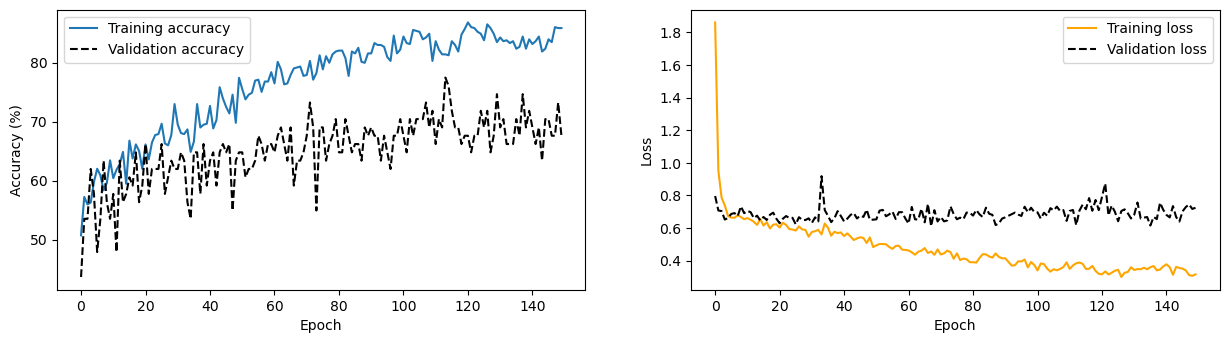

1/1 [==============================] - 1s 1s/step


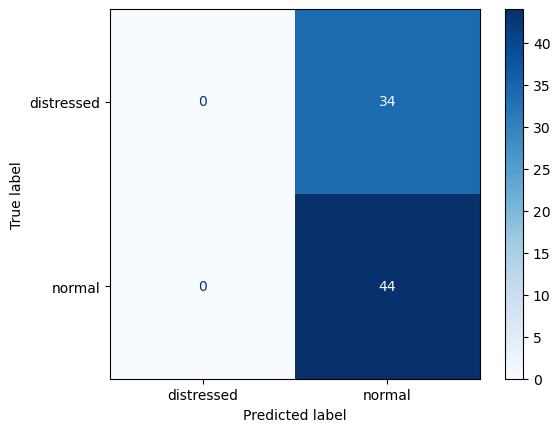

In [11]:
resnet(epochs=150, layer_1000=True, dropout_2=True)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 dense_2 (Dense)             (None, 100)               204900    
                                                                 
 dropout_1 (Dropout)         (None, 100)               0         
                                                                 
 dense_3 (Dense)             (None, 100)               10100     
                                                                 
 dropout_2 (Dropout)         (None, 100)               0         
                                                                 
 dense_4 (Dense)             (None, 1)                 101       
                                                                 
Total params: 23802813 (90.80 MB)
Trainable params: 21

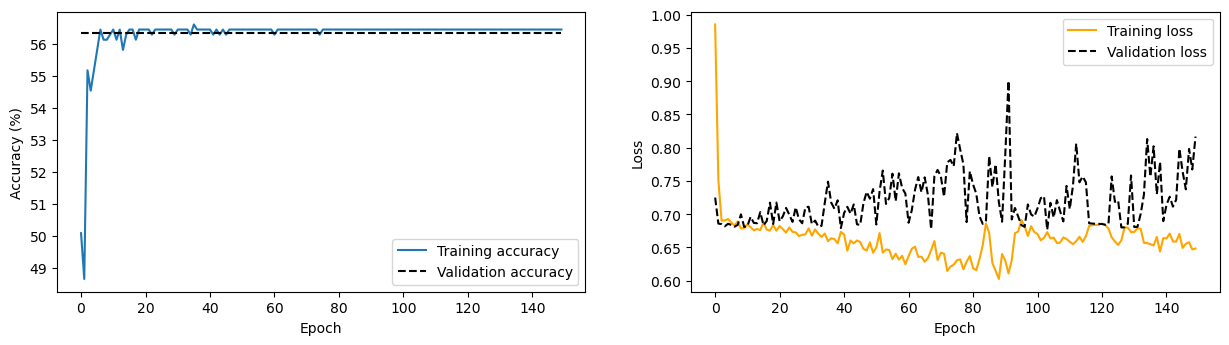

1/1 [==============================] - 0s 51ms/step


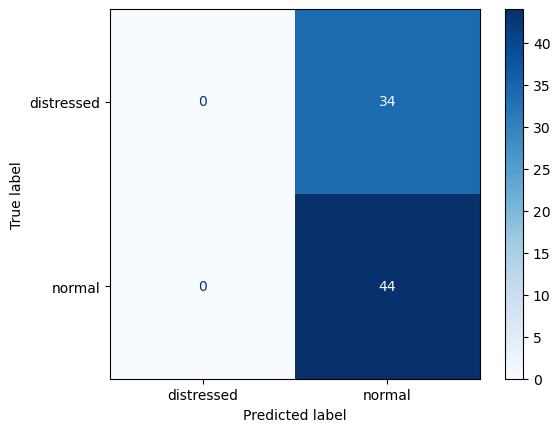

In [12]:
resnet(epochs=150, dense100_1=True, dropout_1=True,
       dense100_2=True, dropout_2=True)